In [1]:
import os
import collections
import time
from collections import Counter

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

This dataset contains transactions made by credit cards in September 2013 by European cardholder in the span of two days. The highly imbalanced dataset consists of 492 fradulent transactions out of 284,807 total transactions. Due to privacy issues, feature names and detailes have been redacted.

Data Source: [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)


In [2]:
df = pd.read_csv(r'data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The transformed features, V1 through V28 have already been transformed. However, "Time" and "Amount" have not been transformed. The untransformed features will be transformed before fitting the models.

We can see that data is highly skewed since only 0.17% of the transactions are fradulent. If we use the baseline dataset without addressing the skewness, the model will most likely be useless. For instance, if we classify all the transactions as non-fradulent, the model would be 99.87% accurate but the problem would remain unsolved. 

The following code implements over- and under-fitting techniques to predict the fradulent transactions. To evaluate the model performance, confusion matrix will be primarily used in addition to the following metrics:

$$\text{precison} = \frac{\text{TP}}{\text{TP}+ \text{FP}} $$

$$\text{recall} = \frac{\text{TP}}{\text{TP}+ \text{FN}} $$

$$\text{F1-score} = \frac{2\times \text{precision}\times \text{recall}}{\text{precision}+ \text{recall}} $$

$$\text{accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP}+ \text{TN} + \text{FP}+ \text{FN}} $$


In [3]:
print(df.groupby('Class').size()[1] / len(df) * 100, '% of the transactions are fradulent')
df.groupby('Class').size()

0.1727485630620034 % of the transactions are fradulent


Class
0    284315
1       492
dtype: int64

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

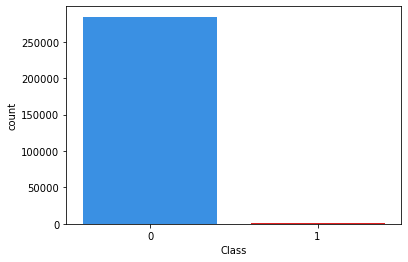

In [5]:
sns.countplot('Class', data = df, palette = ['dodgerblue', 'red']);

To scale unscaled features (Time and Amount), the following transformations are considered

The robust scalar removes the median and scales the data according to the quantile range (defaults to interquantile range (IQR)). IQR is the range between the $25^{th}$ and the $75^{th}$ quartile. Robust is used because the influence of outliers is minimal. 

$$X_{Robust} = \frac{x_i - x_{50}}{x_{75} - x_{25}} $$

$$X_{MinMax} = \frac{x_i - min(x)}{max(x) - min(x)} $$

$$X_{Standard} = \frac{x_i - mean(x)}{std(x)} $$

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler

robust_scaler = RobustScaler()

df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)


The scaled time and amount are correlated to almost all of the features. The correlations are capped around 0.4. If the correlations were more widespread, an in-depth exploration of the correlation matrix would have been appropriate. Given the minimal instances of high correlation (negative or positive), I am making a judgement call that collinearity will not be an issue.   

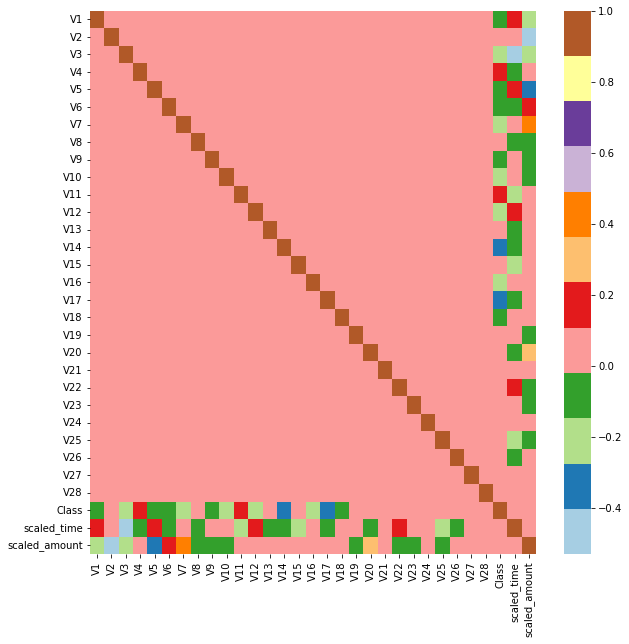

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap= 'Paired');

In [8]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

overSample = RandomOverSampler(sampling_strategy = 'minority')
underSample = RandomUnderSampler(sampling_strategy = 'majority')

X = df.drop('Class', axis=1)
y = df['Class']

x_over, y_over = overSample.fit_resample(X, y)
x_under, y_under = underSample.fit_resample(X, y)


Following is the demonstration of implementation of over- and under-sampling. Note that the variables are not directly used in the model. I use pipeline for the ease of implementation. 

In [9]:
print(x_under.shape, y_under.shape)
print(Counter(y_under))

(984, 30) (984,)
Counter({0: 492, 1: 492})


In [10]:
print(x_over.shape, y_over.shape)
print(Counter(y_over))

(568630, 30) (568630,)
Counter({0: 284315, 1: 284315})


In [11]:
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(x_under.values, y_under.values, test_size=0.2, random_state=42)

classifiers_list = [
     LogisticRegression(),
     KNeighborsClassifier(),
     LinearSVC(),
     DecisionTreeClassifier(),
     XGBClassifier(eval_metric = 'mlogloss'),
     RandomForestClassifier(),
     CatBoostClassifier(verbose=0)
]

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix

def fit_models(classifier_list, df, sampling_type, test_split = 0.2, random_state = 42,sub_sample_ratio = None):
    
    '''
    sampling_type options: ['over', 'under', 'SMOTE']
    '''
    
    if sub_sample_ratio != None:
        df = df.sample(frac = sub_sample_ratio, random_state=1, replace = False)
    else: pass
    
    X = df.drop('Class', axis=1)
    y = df['Class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = random_state)
    
    d = {'Classifier':[],
         'Training Accuracy':[],
         'Testing Accuracy':[],
         'F1 Score':[],
         'Precision':[],
         'Recall':[],
         'Confusion Matrix':[]
        }

    for classifier in classifier_list:
        if sampling_type == 'over':
            steps = [('over', RandomOverSampler()), ('model', classifier)]
        elif sampling_type == 'under':
            steps = [('under', RandomUnderSampler()), ('model', classifier)]
        else:
            steps = [('smt', SMOTE()), ('model', classifier)]
            
        pipeline = Pipeline(steps = steps)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        
        d['Classifier'].append(classifier.__class__.__name__)
        training_score = cross_val_score(pipeline, X_train, y_train, cv=cv)
        d['Training Accuracy'].append(training_score.mean())
        y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)
        d['Testing Accuracy'].append(accuracy_score(y_test, y_pred))
        d['F1 Score'].append(f1_score(y_test, y_pred))
        d['Precision'].append(precision_score(y_test, y_pred))
        d['Recall'].append(recall_score(y_test, y_pred))
        d['Confusion Matrix'].append(confusion_matrix(y_test, y_pred))
    performance = pd.DataFrame(data = d).set_index('Classifier')
    return performance



### Undersampling 

In [13]:
performance_undersampling = fit_models(classifiers_list, df, sampling_type = 'under')
performance_undersampling.head(n=10)

,Training Accuracy,Testing Accuracy,F1 Score,Precision,Recall,Confusion Matrix
Classifier,,,,,,
LogisticRegression,0.964278,0.942488,0.053726,0.027646,0.948980,"[[53593, 3271], [5, 93]]"
KNeighborsClassifier,0.973176,0.977722,0.119362,0.064036,0.877551,"[[55607, 1257], [12, 86]]"
LinearSVC,0.963976,0.907710,0.033817,0.017219,0.938776,"[[51613, 5251], [6, 92]]"
DecisionTreeClassifier,0.903436,0.898424,0.029195,0.014841,0.887755,"[[51089, 5775], [11, 87]]"
XGBClassifier,0.959948,0.973000,0.104773,0.055556,0.918367,"[[55334, 1530], [8, 90]]"
RandomForestClassifier,0.973049,0.976914,0.116857,0.062545,0.887755,"[[55560, 1304], [11, 87]]"
CatBoostClassifier,0.975296,0.985552,0.174524,0.096774,0.887755,"[[56052, 812], [11, 87]]"


Did not run the following chunk of codes because the computational time was too long.

### SMOTE 

It creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

Reference: [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813)

In [ ]:
performance_xgb = fit_models(classifiers_list[4:6], df, sampling_type = 'SMOTE')
performance_xgb.head(n=10)

In [ ]:
performance_oversampling = fit_models(classifiers_list, df, sampling_type='over' )
performance_oversampling.head(n=10)

### Hyperparameter tuning

In [ ]:
def tune_hyperparams(classifier, df, param_grid, sampling_type = 'under', test_split = 0.2, random_state = 42 
                             ,sub_sample_ratio = None):
    
    if sub_sample_ratio != None:
        df = df.sample(frac = sub_sample_ratio, random_state=1, replace = False)
    else: pass
    
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = random_state)
    
    grid_clf = RandomizedSearchCV(classifier, param_grid, n_iter=10, n_jobs = 10, cv = 10,
                                  scoring='accuracy', refit = False, random_state = 0, verbose = 0)

    grid_clf.fit(X_train, y_train)

    best_score = grid_clf.best_score_
    param_recommend = grid_clf.best_params_
    print(best_score*100, param_recommend)
    
    best_model = grid_clf.best_estimator_

    return best_model


In [ ]:
param_grid = {
    'n_estimators':[10, 30, 50, 70, 90, 150, 200],
    'max_depth':[100,200,300,400,500,600,700,800,1000,2000]
}
xgb_tuned = tune_hyperparams(XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss'),
                             df, param_grid, sampling_type = 'under', test_split = 0.2, random_state = 42 
                             ,sub_sample_ratio = None)

In [ ]:
from sklearn.metrics import classification_report

y_pred = xgb_tuned.predict(X_test)
print(classification_report(y_test, y_pred_tree))